# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.3 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-dpk_65bk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-dpk_65bk
  Resolved https://github.com/huggingface/accelerate to commit d5894ab4992878c191ed4c9fdb53b35ad2c0e628
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=247982 sha256=90b6fed2d24428588d0d0a13e9c37d30257ab30f241d63f5ad2323abbd92208b
  Stored in directory: /tmp/pip-ephem-wheel-cache-vy8uwga4/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


# Load data and pre-processing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [6]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [31]:
df=pd.read_csv("/content/drive/MyDrive/yahoo_QA/train.csv",names=['class', 'title', 'content', 'answer'])


In [32]:
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'}

In [33]:
labels=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference',
        'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music',
        'Family & Relationships', 'Politics & Government']

In [34]:
df['label'] = df['class'].map(categories)

In [35]:
df = df.drop('class', axis=1)

In [36]:
label_dict = dict(zip(labels, range(0,len(labels))))
df['index']=df['label'].apply(labels.index)

In [37]:
df.groupby(['label']).size()

label
Business & Finance        140000
Computers & Internet      140000
Education & Reference     140000
Entertainment & Music     140000
Family & Relationships    140000
Health                    140000
Politics & Government     140000
Science & Mathematics     140000
Society & Culture         140000
Sports                    140000
dtype: int64

# Model

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [17]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['title'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [19]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [20]:
import torch
torch.cuda.empty_cache()

In [21]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Train (r ratio)


In [ ]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 605)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),197)
health_idx=random.sample(list(df.query('label=="Health"').index),346)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),183)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),944)

# Use indices to select data
df1= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [ ]:
from sklearn.utils import shuffle
df1= shuffle(df1)

In [22]:
train, test = train_test_split(df1, test_size=0.2)
valid, test = train_test_split(test, test_size=0.5)

In [23]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
# define parameters
EPOCHS = 5

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [26]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.0243826309839885 accuracy 0.6620879120879121


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 0.7852292597293854 accuracy 0.09395604395604396

Epoch 2/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.5134513200375072 accuracy 0.8307692307692308


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 0.7805931816498438 accuracy 0.09395604395604396

Epoch 3/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.24509379534018144 accuracy 0.9241758241758242


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.1496765315532684 accuracy 0.0945054945054945

Epoch 4/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.12385617783946688 accuracy 0.9642857142857143


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.1160677333672842 accuracy 0.0956043956043956

Epoch 5/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.05821008612238394 accuracy 0.9813186813186813


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.1373333434263866 accuracy 0.09725274725274725



In [27]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [28]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.6718819011475559

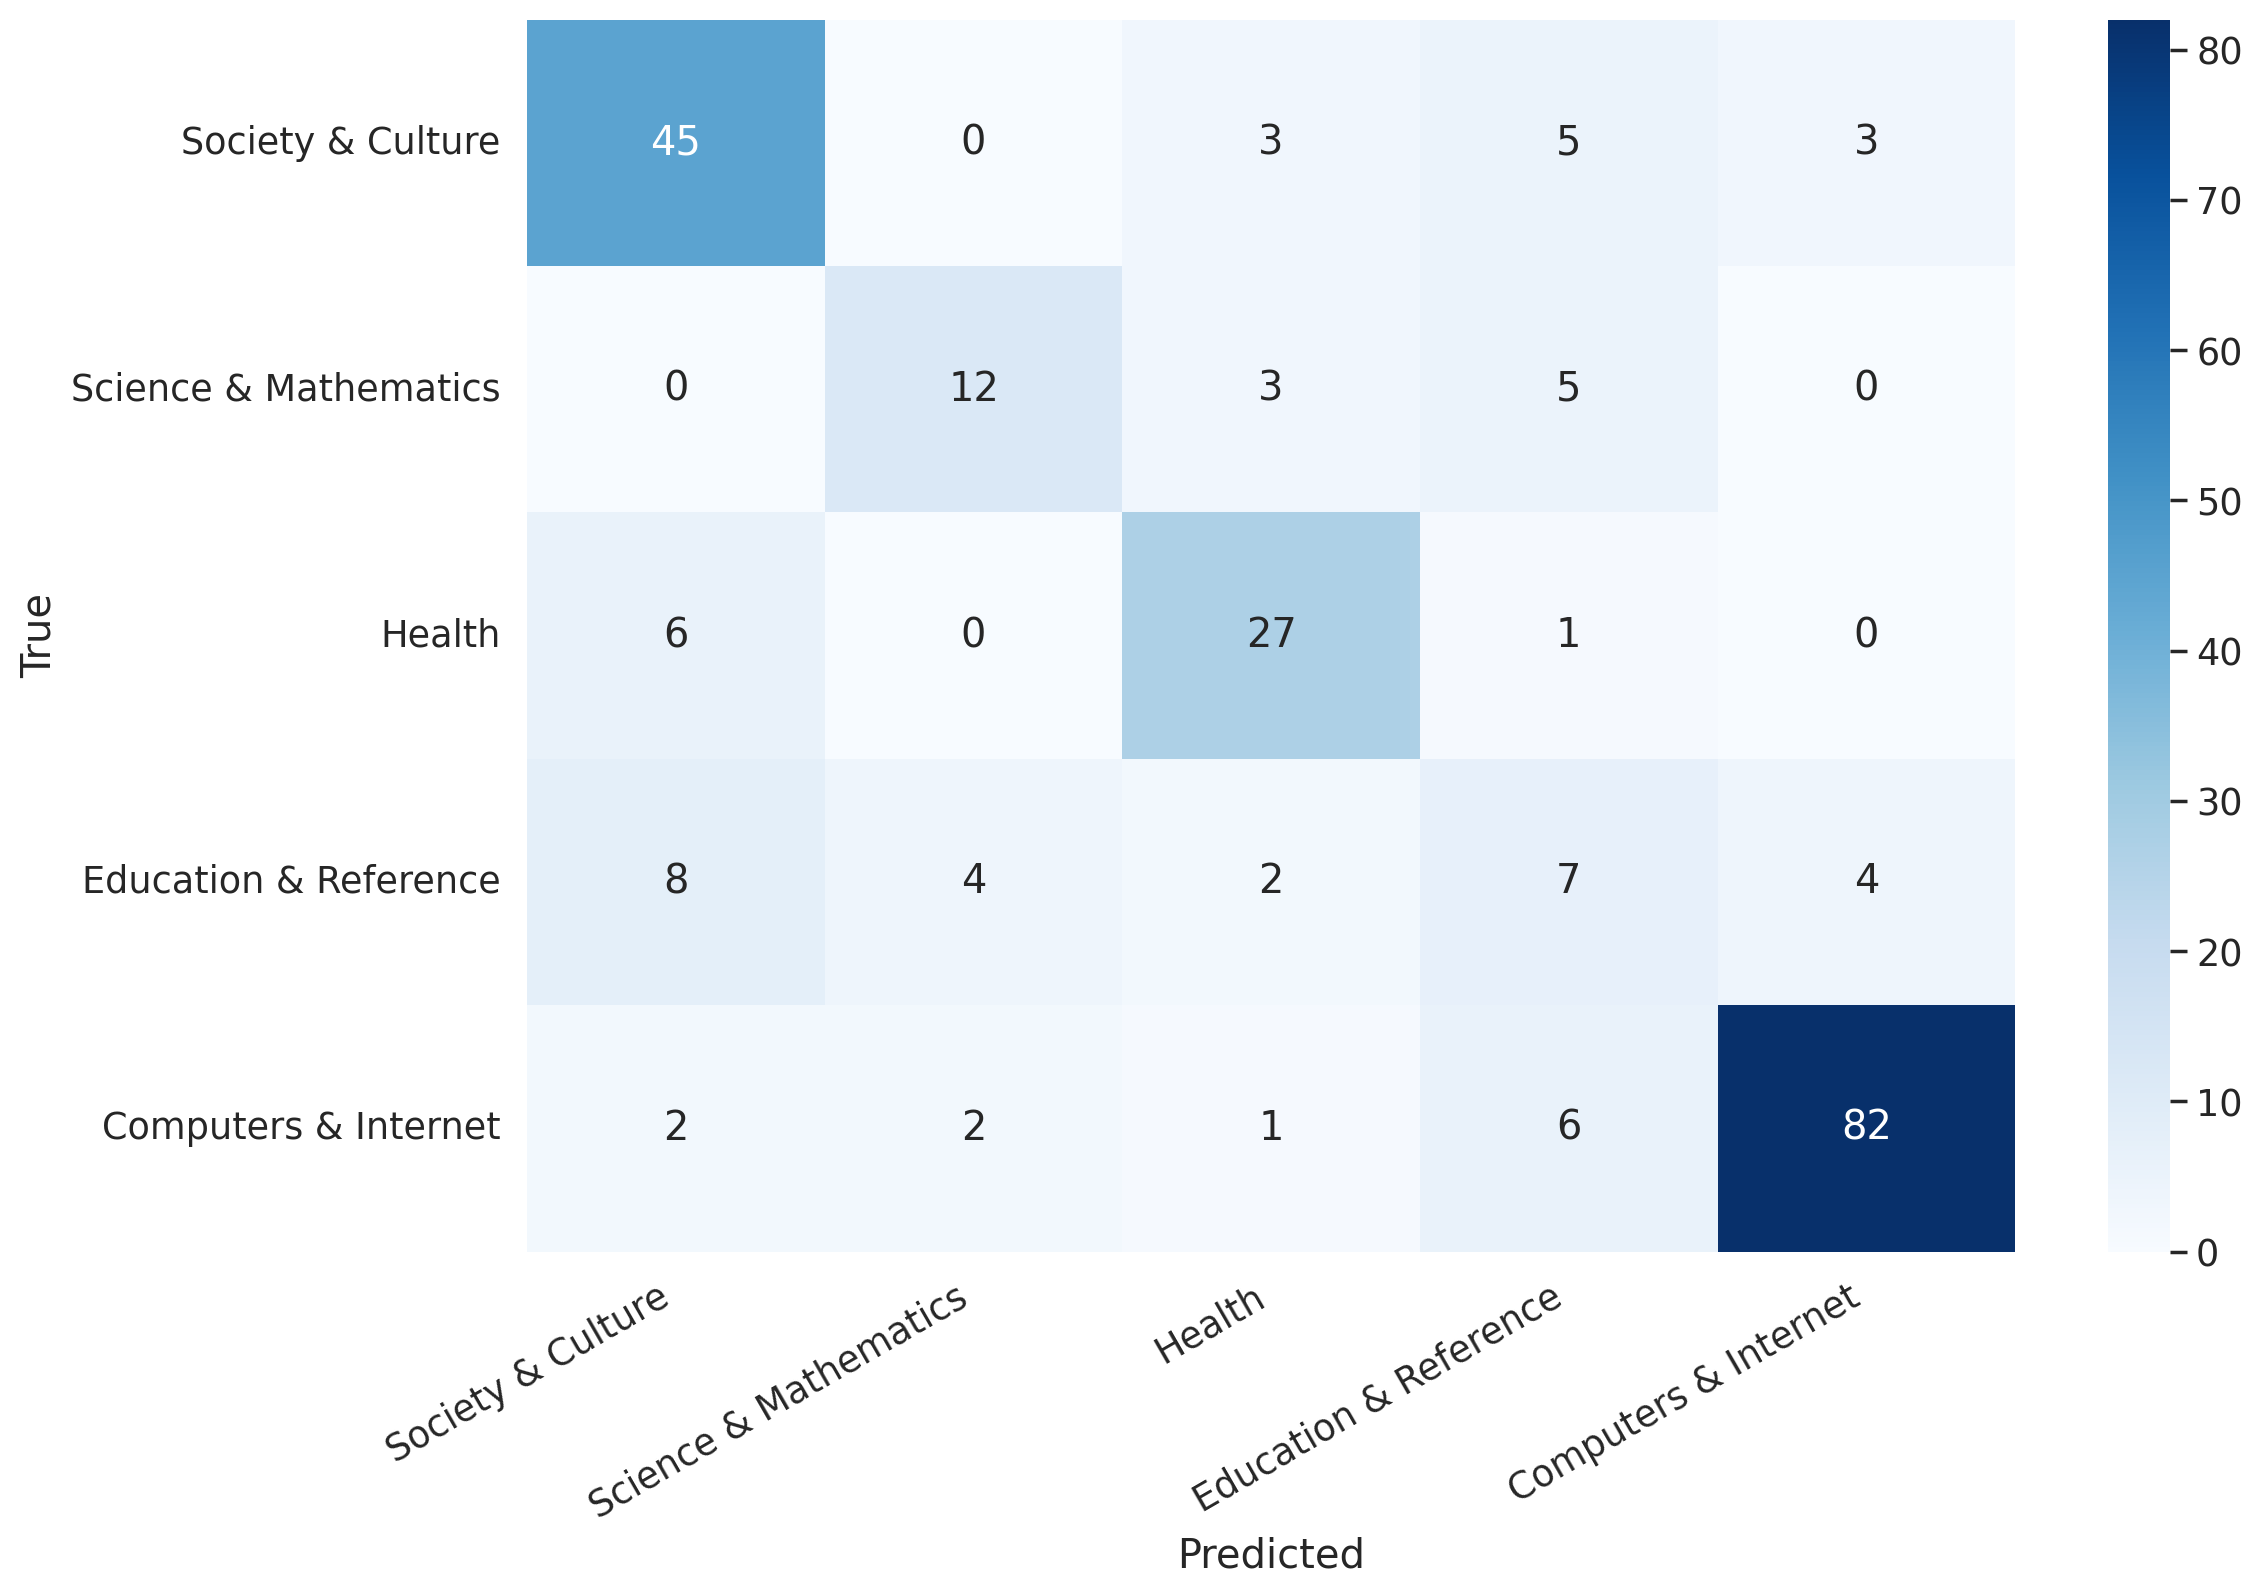

In [29]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [30]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.74      0.80      0.77        56
Science & Mathematics       0.67      0.60      0.63        20
               Health       0.75      0.79      0.77        34
Education & Reference       0.29      0.28      0.29        25
 Computers & Internet       0.92      0.88      0.90        93

             accuracy                           0.76       228
            macro avg       0.67      0.67      0.67       228
         weighted avg       0.76      0.76      0.76       228



# Train (p ratio)


In [38]:
import random
#1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference', 5: 'Computers & Internet'
# Return a list of indices
cul_idx=random.sample(list(df.query('label=="Society & Culture"').index), 555)
sci_idx=random.sample(list(df.query('label=="Science & Mathematics"').index),131)
health_idx=random.sample(list(df.query('label=="Health"').index),535)
edu_idx=random.sample(list(df.query('label=="Education & Reference"').index),240)
comp_idx=random.sample(list(df.query('label=="Computers & Internet"').index),359)

# Use indices to select data
df2= df.loc[cul_idx + sci_idx + health_idx+ edu_idx + comp_idx]
index_list2=cul_idx + sci_idx + health_idx+ edu_idx + comp_idx

In [39]:
from sklearn.utils import shuffle
df2= shuffle(df2)

In [40]:
train, test = train_test_split(df2, test_size=0.2)
valid, test = train_test_split(test, test_size=0.5)

In [41]:
train_data_loader = create_data_loader(train, tokenizer, max_len=128, batch_size=16)
val_data_loader = create_data_loader(valid, tokenizer, max_len=128, batch_size=16)
test_data_loader = create_data_loader(test, tokenizer, max_len=128, batch_size=16)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [43]:
# define parameters
EPOCHS = 5

model = Classifier(len(labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [44]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.2104550410103012 accuracy 0.5583791208791209


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 0.7148022825519244 accuracy 0.09271978021978022

Epoch 2/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.5994269227261072 accuracy 0.8118131868131869


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 0.747774084409078 accuracy 0.09478021978021979

Epoch 3/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.3358617114251132 accuracy 0.903846153846154


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 0.8574119902526339 accuracy 0.09134615384615385

Epoch 4/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.18138367744101272 accuracy 0.9546703296703297


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 0.9465536251664162 accuracy 0.09340659340659341

Epoch 5/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 0.10568705791668905 accuracy 0.9766483516483517


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.012768477589513 accuracy 0.0940934065934066



In [45]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader)

In [46]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.7425521821631879

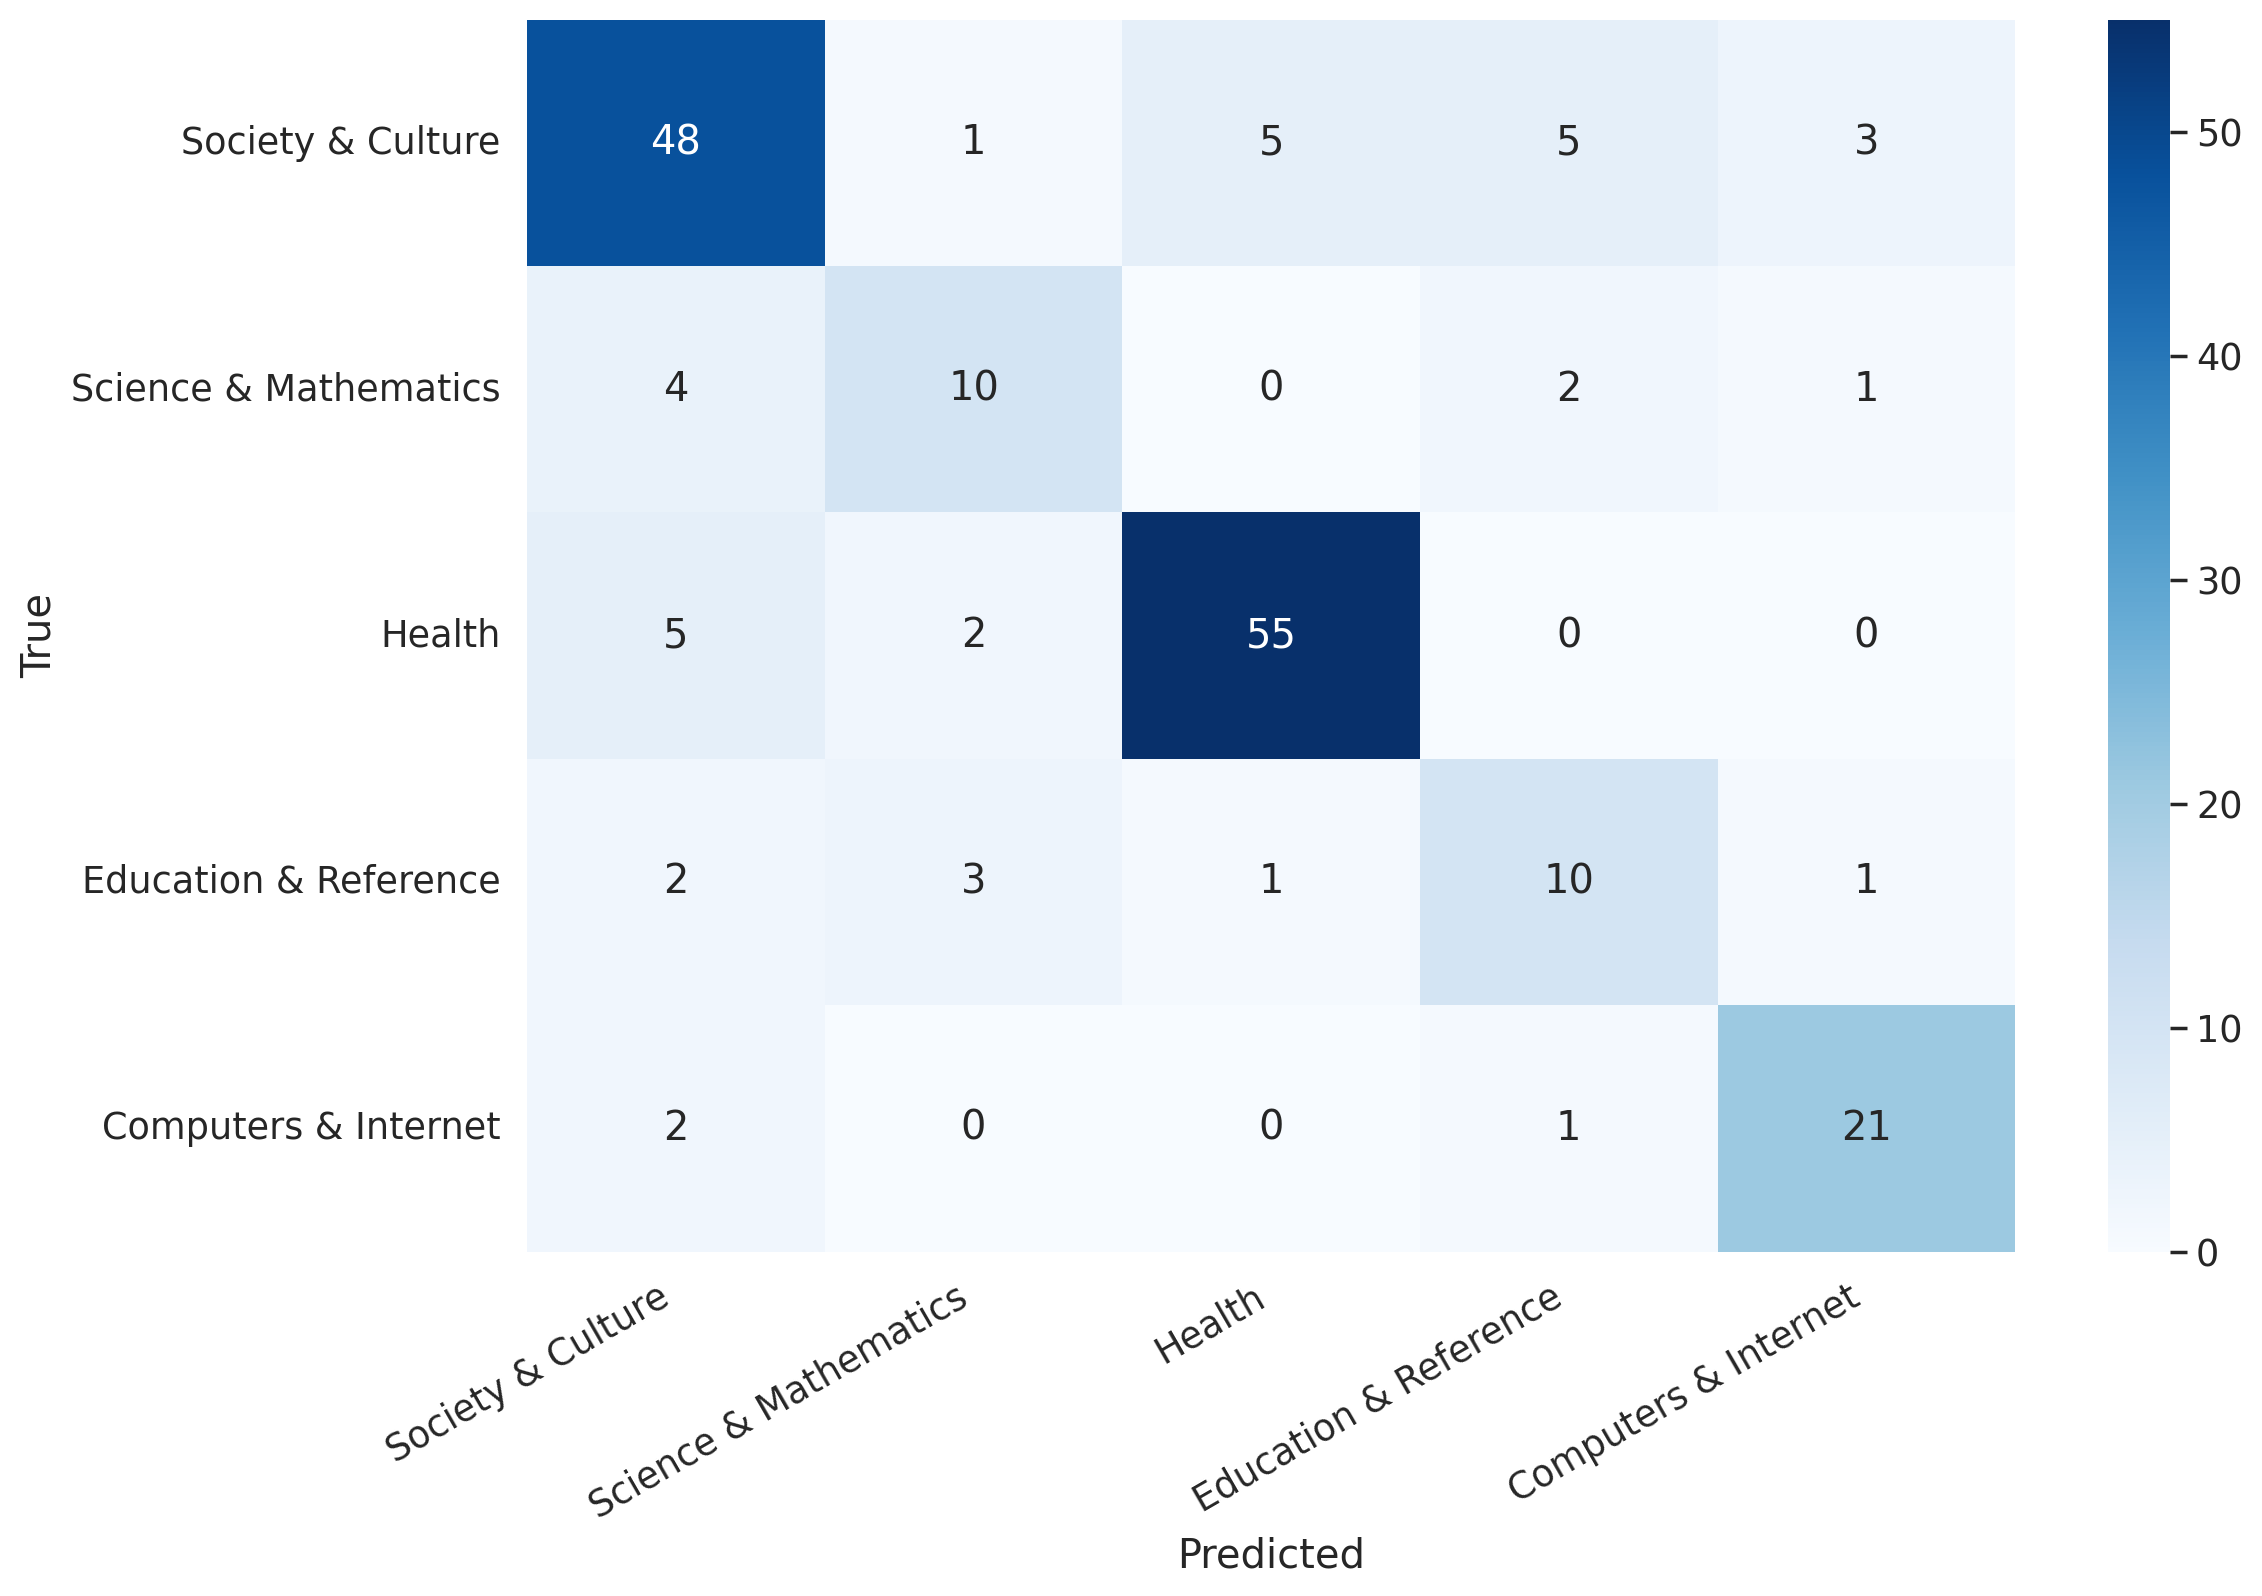

In [47]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels[0:5], columns=labels[0:5])
show_confusion_matrix(df_cm)

In [48]:
print(classification_report(y_test, y_pred, target_names=labels[0:5]))

                       precision    recall  f1-score   support

    Society & Culture       0.79      0.77      0.78        62
Science & Mathematics       0.62      0.59      0.61        17
               Health       0.90      0.89      0.89        62
Education & Reference       0.56      0.59      0.57        17
 Computers & Internet       0.81      0.88      0.84        24

             accuracy                           0.79       182
            macro avg       0.74      0.74      0.74       182
         weighted avg       0.79      0.79      0.79       182

